Title: Processed Heart Failure Data from Cleveland

Introduction: There are many indicators of the likelihood of heart disease in patients, often discernible through various traits. Heart failure typically occurs when the heart does not pump blood at a sufficient rate. It can cause fluid buildup in the lungs, resulting in symptoms such as shortness of breath, fatigue/weakness, nausea, coughing/wheezing, rapid weight gain, and chest pain. The Heart Failure dataset is collected from hospitals in Cleveland, Ohio. It analyzes many variables that could suggest the presence of heart disease, such as age and maximum heart rate achieved (bpm). The question we are trying to answer is: ‘How likely is a person to experience heart failure, based on their age and maximum heart rate (bpm)?’

In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:tidyr’:

    matches


Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────

In [14]:
cleveland_data <- read_csv("data/processed.cleveland.data", col_names = FALSE)
# data was downloaded off https://archive.ics.uci.edu/ml/datasets/Heart+Disease, then uploaded to Jupyter
cleveland_data

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


In [15]:
colnames(cleveland_data) <- c("age", "sex", "cp", "rbp", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
cleveland_data

cleveland_data <- cleveland_data %>%
    mutate(num = as.factor(num)) %>%
    select(age, thalach, num)
cleveland_data

age,sex,cp,rbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


age,thalach,num
<dbl>,<dbl>,<fct>
63,150,0
67,108,2
67,129,1
⋮,⋮,⋮
57,115,3
57,174,1
38,173,0


age,thalach,num
<dbl>,<dbl>,<fct>
67,108,2
67,129,1
41,172,0
⋮,⋮,⋮
57,115,3
57,174,1
38,173,0


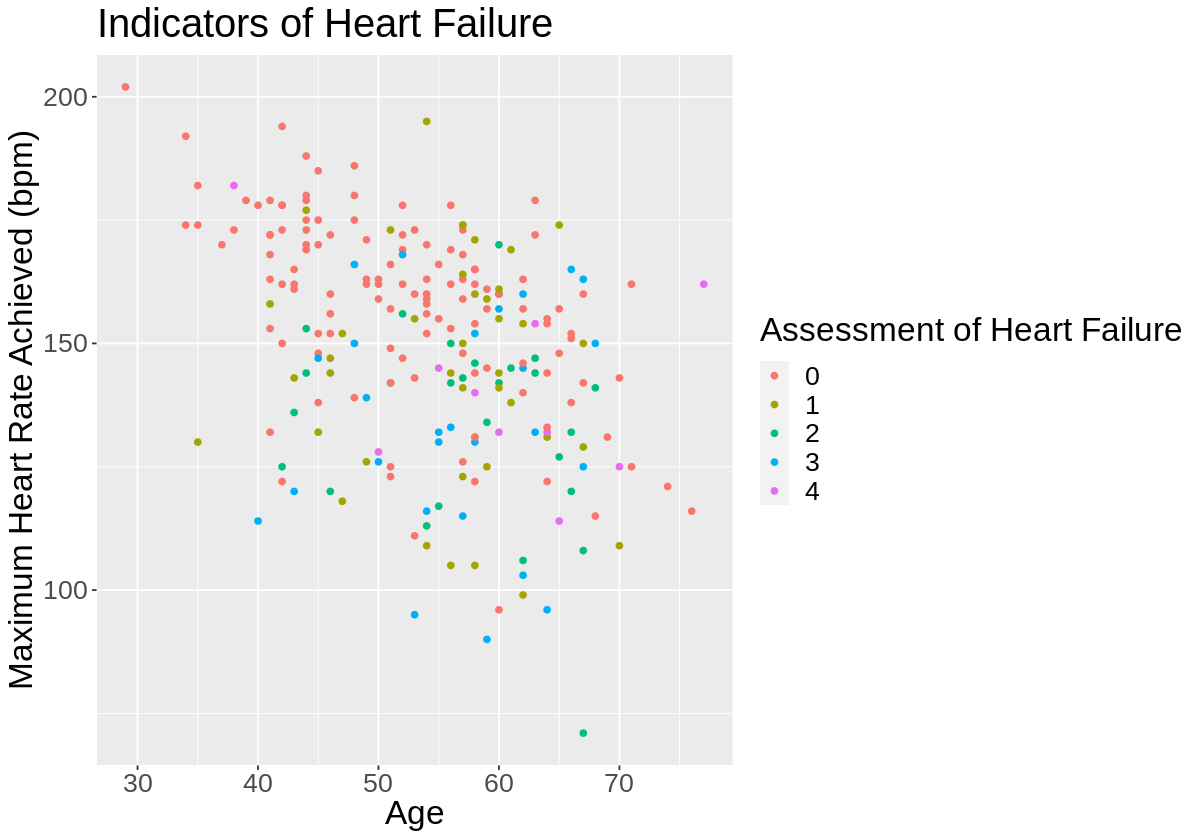

In [76]:
set.seed(42069)
cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = num)
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)
cleveland_training

options(repr.plot.width = 10, reppr.plot.height = 10)
cleveland_plot <- cleveland_training %>%
    ggplot(aes(x = age, y = thalach, color = num)) +
    geom_point() +
    labs(x = "Age", y = "Maximum Heart Rate Achieved (bpm)", color = "Assessment of Heart Failure") +
    ggtitle("Indicators of Heart Failure") +
    theme(text = element_text(size=20))
cleveland_plot

Methods: For the data analysis, we will be using two predictors, age and maximum heart rate achieved (bpm), to predict likelihood of heart failure for new observations. Using several tidying techniques, we have cleaned and wrangled the data to make it easier to discern. First, we read the data into Jupyter using the read_csv function. Then, we renamed the columns using the original dataset. After that, we selected the columns that correspond to age and maximum heart rate achieved and summarized the data in a table. We also split the data into training and testing sets. Lastly, we created a scatter plot with age on the x-axis and maximum heart rate on the y-axis, including human-readable labels and a necessary title to help with the clarity of the visualization. We colored values from 1 to 4, with 0 indicating the absence of heart disease, and numbers 1-4 indicating the severity of the present heart disease (4 being most severe). From here, we can observe the relationship between age and maximum heart rate with regards to heart disease. This will be our main form of visualization since we aim to observe the relationship between two unordered variables. 
Additionally, we will utilize git for our version control system and Github to store our data analysis in a cloud-based repository. 

In [77]:
heart_fold <- vfold_cv(cleveland_training, v = 5, strata = num)

In [78]:
heart_recipe <- recipe(num ~ ., data = cleveland_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())
heart_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [79]:
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")
heart_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [80]:
gridvals <- tibble(neighbors = c(1:20))

In [81]:
heart_fit <- workflow() %>%
    add_recipe(heart_recipe) %>%
    add_model(heart_spec) %>%
    tune_grid(resamples = heart_fold, grid = gridvals) %>%
    collect_metrics()
heart_fit

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.3833454,5,0.04201385,Model01
1,roc_auc,hand_till,0.4871031,5,0.01708051,Model01
2,accuracy,multiclass,0.3833454,5,0.04201385,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
19,roc_auc,hand_till,0.5513122,5,0.02267740,Model19
20,accuracy,multiclass,0.5109300,5,0.01152167,Model20
20,roc_auc,hand_till,0.5430641,5,0.02440126,Model20


In [82]:
k_best <- heart_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(desc(mean)) %>%
    select(neighbors) %>%
    slice(1) %>%
    pull()
k_best

[1] 18

In [83]:
best_heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = k_best) %>%
    set_engine("kknn") %>%
    set_mode("classification")

heart_fit_best <- workflow() %>%
    add_recipe(heart_recipe) %>%
    add_model(best_heart_spec) %>%
    fit(cleveland_training)
heart_fit_best

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~k_best,     kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4847162
Best kernel: rectangular
Best k: 18

In [84]:
heart_summary <- heart_fit_best %>%
    predict(cleveland_testing) %>%
    bind_cols(cleveland_testing) %>%
    metrics(truth = num, estimate = .pred_class) %>%
    filter(.metric == "accuracy")
heart_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5945946
